## Parte 2. Selección e Ingeniería de caracteristicas

In [2]:
# importar librerias
import numpy as np
import pandas as pd

In [3]:
df_processed = pd.read_csv('../data/processed/bike_sharing_processed.csv')
df_fe = df_processed.copy()

In [4]:
df_fe.shape

(17531, 17)

In [5]:
# Revisando tipado de datos
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17531 entries, 0 to 17530
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17531 non-null  object 
 1   season      17531 non-null  int64  
 2   yr          17531 non-null  int64  
 3   mnth        17531 non-null  int64  
 4   hr          17531 non-null  int64  
 5   holiday     17531 non-null  int64  
 6   weekday     17531 non-null  int64  
 7   workingday  17531 non-null  int64  
 8   weathersit  17531 non-null  int64  
 9   temp        17531 non-null  float64
 10  atemp       17531 non-null  float64
 11  hum         17531 non-null  float64
 12  windspeed   17531 non-null  float64
 13  casual      17531 non-null  int64  
 14  registered  17531 non-null  int64  
 15  cnt         17531 non-null  int64  
 16  instant     17531 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [6]:
# fechas
if not np.issubdtype(df_fe['dteday'].dtype, np.datetime64):
    df_fe['dteday'] = pd.to_datetime(df_fe['dteday'], errors='coerce')

# datos con tipo de dato entero
for c in ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit','instant']:
    if c in df_fe:
        df_fe[c] = pd.to_numeric(df_fe[c], errors='coerce').round().astype('Int64')

# datos con tipo de dato continuo
for c in ['temp','atemp','hum','windspeed','cnt']:
    if c in df_fe:
        df_fe[c] = pd.to_numeric(df_fe[c], errors='coerce')

### Generamos más variables a partir de las existentes para ayudar a la interpretabilidad

In [7]:
# Temporales derivadas
df_fe['dayofyear'] = df_fe['dteday'].dt.dayofyear
df_fe['is_weekend'] = df_fe['weekday'].isin([0,6]).astype(int)

# Codificación cíclica: ayuda a que el modelo entienda que son ciclos
# hora (0-23)
df_fe['hr_sin']  = np.sin(2*np.pi * df_fe['hr'].astype(float) / 24.0)
df_fe['hr_cos']  = np.cos(2*np.pi * df_fe['hr'].astype(float) / 24.0)

# mes (1-12)
df_fe['mnth_sin'] = np.sin(2*np.pi * df_fe['mnth'].astype(float) / 12.0)
df_fe['mnth_cos'] = np.cos(2*np.pi * df_fe['mnth'].astype(float) / 12.0)

# día del año (1-366)
df_fe['doy_sin'] = np.sin(2*np.pi * df_fe['dayofyear'].astype(float) / 366.0)
df_fe['doy_cos'] = np.cos(2*np.pi * df_fe['dayofyear'].astype(float) / 366.0)

# Interacciones climáticas simples (no lineales y combinaciones útiles)
df_fe['temp_diff']  = df_fe['atemp'] - df_fe['temp']       # sensación - temperatura
df_fe['temp_x_hum'] = df_fe['temp'] * df_fe['hum']         # bochorno aproximado
df_fe['wind_sq']    = df_fe['windspeed'] ** 2              # relación no lineal con viento

In [8]:
# 5) Chequeo rápido
added = [
    'dayofyear','is_weekend',
    'hr_sin','hr_cos','mnth_sin','mnth_cos','doy_sin','doy_cos',
    'temp_diff','temp_x_hum','wind_sq'
]
print("Nuevas columnas:", added)
print("Shape antes:", df_processed.shape, "→ después:", df_fe.shape)
df_fe[added + ['cnt']].head(3)

Nuevas columnas: ['dayofyear', 'is_weekend', 'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos', 'doy_sin', 'doy_cos', 'temp_diff', 'temp_x_hum', 'wind_sq']
Shape antes: (17531, 17) → después: (17531, 28)


,dayofyear,is_weekend,hr_sin,hr_cos,mnth_sin,mnth_cos,doy_sin,doy_cos,temp_diff,temp_x_hum,wind_sq,cnt
0,1,0,0.000000,1.000000,0.5,0.866025,0.017166,0.999853,0.0479,0.1944,0.0,16
1,1,0,0.258819,0.965926,0.5,0.866025,0.017166,0.999853,0.0527,0.1760,0.0,40
2,1,0,0.500000,0.866025,0.5,0.866025,0.017166,0.999853,0.0527,0.1760,0.0,32


In [9]:
from sklearn.preprocessing import OneHotEncoder

# Copia del DF
df_enc = df_fe.copy()

# Solo las categóricas verdaderas
cat_cols = ['weekday', 'weathersit']

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_enc[cat_cols])
encoded_cols = encoder.get_feature_names_out(cat_cols)
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df_enc.index)

# Concatenamos
df_model = pd.concat([df_enc.drop(columns=cat_cols), df_encoded], axis=1)

print("Shape original:", df_fe.shape)
print("Shape con one-hot:", df_model.shape)
print("Nuevas columnas:", list(encoded_cols))
df_model.head(3)


Shape original: (17531, 28)
Shape con one-hot: (17531, 35)
Nuevas columnas: ['weekday_1.0', 'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0', 'weekday_6.0', 'weathersit_2.0', 'weathersit_3.0', 'weathersit_4.0']


,dteday,season,yr,mnth,hr,holiday,workingday,temp,atemp,hum,...,wind_sq,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weathersit_2.0,weathersit_3.0,weathersit_4.0
0,2011-01-01,1,0,1,0,0,0,0.24,0.2879,0.81,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2011-01-01,1,0,1,1,0,0,0.22,0.2727,0.80,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2011-01-01,1,0,1,2,0,0,0.22,0.2727,0.80,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


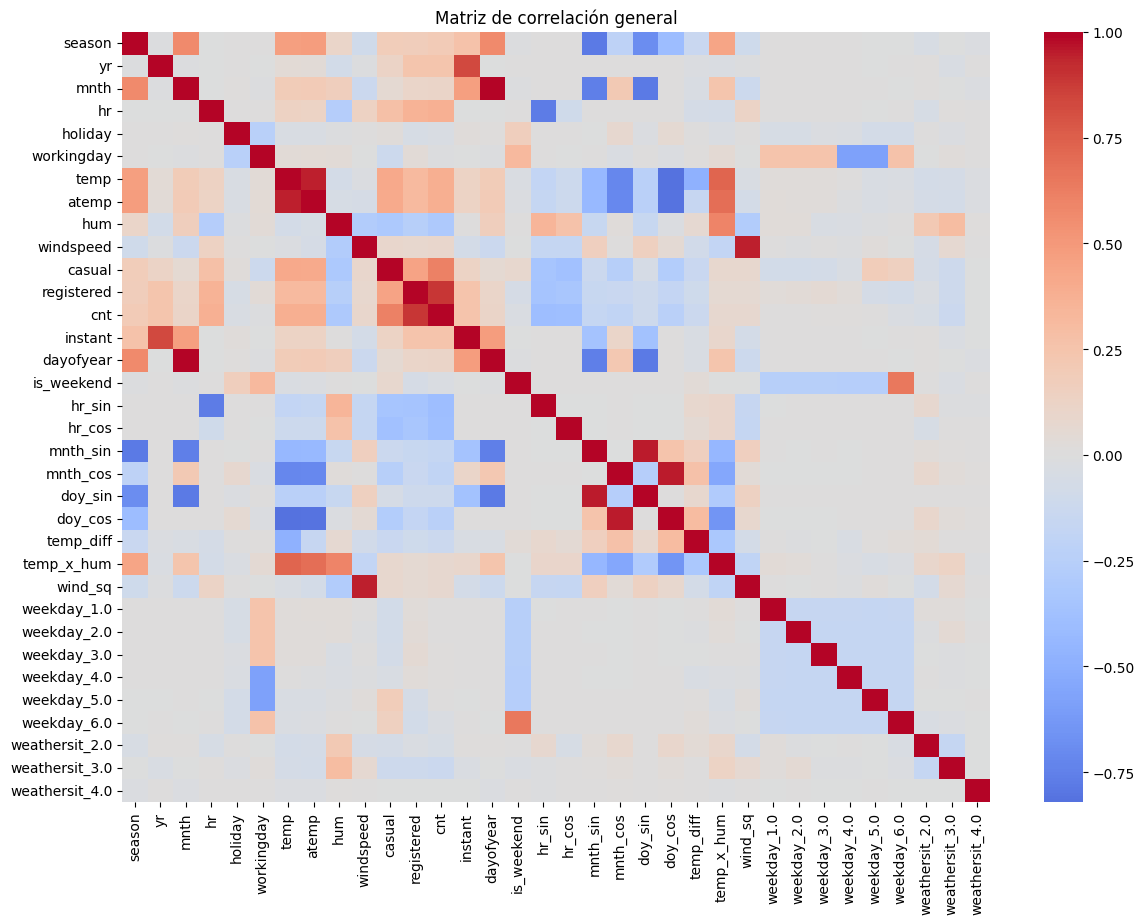

🔹 Correlación con 'cnt':
cnt            1.000000
registered     0.890027
casual         0.615402
temp           0.384210
atemp          0.383344
hr             0.380897
instant        0.259734
yr             0.241352
season         0.199822
mnth           0.117405
dayofyear      0.117077
windspeed      0.092900
wind_sq        0.073344
temp_x_hum     0.070575
weekday_4.0    0.016779
Name: cnt, dtype: float64

🔻 Menor correlación con 'cnt':
weathersit_2.0   -0.048962
doy_sin          -0.115708
weathersit_3.0   -0.125040
temp_diff        -0.130143
mnth_sin         -0.168718
mnth_cos         -0.192509
doy_cos          -0.232249
hum              -0.306246
hr_cos           -0.391844
hr_sin           -0.396999
Name: cnt, dtype: float64

⚠️ Pares altamente correlacionados (>0.9):


,feature_1,feature_2,corr
76,mnth,dayofyear,0.996493
183,temp,atemp,0.944456
275,windspeed,wind_sq,0.944869
442,mnth_sin,doy_sin,0.953208
457,mnth_cos,doy_cos,0.953027


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aseguramos que 'cnt' sea numérica
df_corr = df_model.copy()
df_corr['cnt'] = pd.to_numeric(df_corr['cnt'], errors='coerce')

# Correlaciones solo numéricas
corr = df_corr.corr(numeric_only=True)

# --- 1️⃣ Matriz de correlación general ---
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Matriz de correlación general")
plt.show()

# --- 2️⃣ Correlación con la variable objetivo ---
target_corr = corr['cnt'].sort_values(ascending=False)
print("🔹 Correlación con 'cnt':")
print(target_corr.head(15))
print("\n🔻 Menor correlación con 'cnt':")
print(target_corr.tail(10))

# --- 3️⃣ Identificar pares altamente correlacionados (>0.9) ---
threshold = 0.9
high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'corr'})
)
high_corr_pairs = high_corr_pairs.loc[abs(high_corr_pairs['corr']) > threshold]
print("\n⚠️ Pares altamente correlacionados (>0.9):")
display(high_corr_pairs)


In [11]:
# Eliminar variables redundantes
to_drop = ['dayofyear', 'atemp', 'wind_sq', 'doy_sin', 'doy_cos']
df_selected = df_model.drop(columns=to_drop, errors='ignore')

print("Shape antes:", df_model.shape)
print("Shape después:", df_selected.shape)


Shape antes: (17531, 35)
Shape después: (17531, 30)


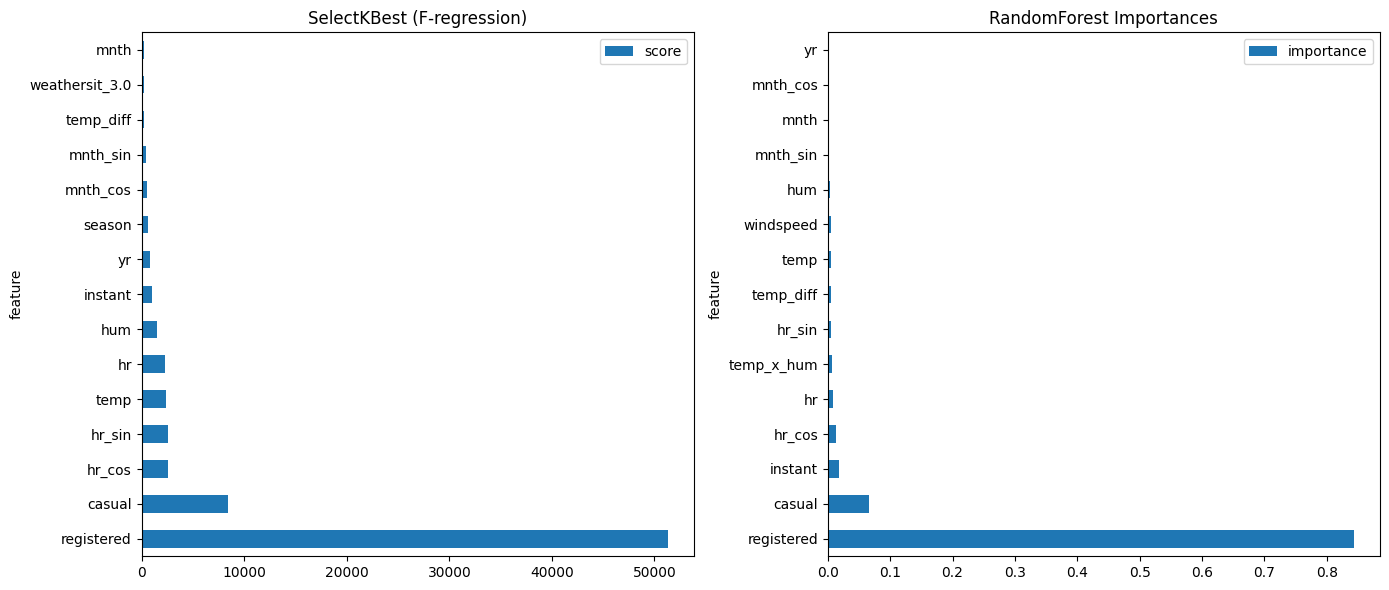

🔹 Top 10 ANOVA:


,feature,score
10,registered,51282.155199
9,casual,8462.913717
14,hr_cos,2561.861922
13,hr_sin,2536.559308
6,temp,2382.155645
3,hr,2320.016875
7,hum,1477.870449
11,instant,984.043672
1,yr,843.228534
0,season,574.430655



🔹 Top 10 RF:


,feature,importance
10,registered,0.843115
9,casual,0.065915
11,instant,0.018517
14,hr_cos,0.013560
3,hr,0.008487
18,temp_x_hum,0.006988
13,hr_sin,0.005517
17,temp_diff,0.005419
6,temp,0.004649
8,windspeed,0.004424


In [13]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- separar X / y
y = df_selected['cnt'].astype(float)
X = df_selected.drop(columns=['cnt'])

# 1) quitar columnas datetime (p. ej., 'dteday')
dt_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
X = X.drop(columns=dt_cols)

# 2) forzar numérico en todo (nullable Int64 -> float)
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')

# 3) asegurar sin NaN (no debería haber, pero por si acaso)
if X.isna().any().any():
    X = X.fillna(0.0)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- SelectKBest (ANOVA/F-test)
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)
anova_scores = pd.DataFrame(
    {'feature': X.columns, 'score': selector.scores_}
).sort_values('score', ascending=False)

# --- Random Forest Importances
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_importances = pd.DataFrame(
    {'feature': X.columns, 'importance': rf.feature_importances_}
).sort_values('importance', ascending=False)

# --- plots rápidos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
anova_scores.head(15).plot.barh(x='feature', y='score', ax=axes[0])
axes[0].set_title('SelectKBest (F-regression)')
rf_importances.head(15).plot.barh(x='feature', y='importance', ax=axes[1])
axes[1].set_title('RandomForest Importances')
plt.tight_layout()
plt.show()

print("🔹 Top 10 ANOVA:")
display(anova_scores.head(10))
print("\n🔹 Top 10 RF:")
display(rf_importances.head(10))


In [14]:
features_final = [
    'temp', 'hum', 'windspeed',
    'season', 'yr', 'mnth', 'hr',
    'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos',
    'is_weekend', 'holiday', 'workingday',
    'weathersit_2.0', 'weathersit_3.0', 'weathersit_4.0',
    'temp_diff', 'temp_x_hum'
]
